<a href="https://colab.research.google.com/github/akankshakusf/Project-DeepLearning-Sentiment-Analysis-of-IMDB-Movie-Reviews/blob/master/Sentiment_Analysis_with_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import ML packages
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pathlib
import io
import string
import time
import re
import numpy as random
import gensim.downloader as api
from PIL import Image
from sklearn.metrics import confusion_matrix, roc_curve

# import tf DL packages
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv1D, InputLayer,BatchNormalization, Bidirectional, Dense, Flatten,Dropout,Input,Embedding,TextVectorization
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, TopKCategoricalAccuracy, CategoricalAccuracy,SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive, files
from tensorboard.plugins import projector

In [2]:
# !pip install --upgrade numpy
# !pip install --upgrade gensim

In [3]:
BATCH_SIZE = 64

# Data Preparation

In [89]:
train_ds,val_ds,test_ds=tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'],as_supervised=True)

In [5]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [6]:
for review,label in val_ds.take(2):
  print(review)
  print(label)

tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
tf.Tensor(1, shape=(),

First we standarize all the values
reference : https://www.tensorflow.org/api_docs/python/tf/strings/regex_replace
- https://github.com/google/re2
- convert to input lowercase
- review html tags through regex (regular expression)
- take off punctuations
- remove special chracters
- remove accented chracters
- reduce the word to root through one of these:
  - Stemming
    - stemming : PorterStemmer
    - lemmatization : Lematize
  - Tokenization
    - chracter tokenization
    - word tokenization
    - subword tokenization
    - n-gram tokenization
  - Vectorization
    - one-hot
    - bag of words
    - tf-idf
    - embeddings
    

- Standardization

In [7]:
def standardization(input_data):
  '''
  Input: raw reviews
  output: standardized reviews
  '''
  lowercase = tf.strings.lower(input_data)
  no_tag = tf.strings.regex_replace(lowercase,"<[^>]+>","")
  output = tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")

  return output


In [8]:
standardization("There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.")

<tf.Tensor: shape=(), dtype=string, numpy=b'there are films that make careers for george romero it was night of the living dead for kevin smith clerks for robert rodriguez el mariachi add to that list onur tukels absolutely amazing dingalingless flawless filmmaking and as assured and as professional as any of the aforementioned movies i havent laughed this hard since i saw the full monty and even then i dont think i laughed quite this hard so to speak tukels talent is considerable dingalingless is so chock full of double entendres that one would have to sit down with a copy of this script and do a linebyline examination of it to fully appreciate the uh breadth and width of it every shot is beautifully composed a clear sign of a surehanded director and the performances all around are solid theres none of the overthetop scenery chewing one mightve expected from a film like this dingalingless is a film whose time has come'>

- Define vocab size and sequence length

In [9]:
VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 250

- reference  : https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

In [10]:
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize= standardization,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
  )


- Note : here in the above cell VOCAB_SIZE, SEQUENCE_LENGTH have been taken up with some guessing values. But we can also take a look at the data understand exactly what the values should be set to


In [ ]:
# this takes while as it is going through all review of samples selected
lengths=[] #initalized empty lists
words=[]

for review, label in train_ds.take(10):
  for word in tf.strings.split(review, sep = ""):
    if word in words:
      pass
    else:
      words.append(word) # append the word to list
  lengths.append(len(tf.strings.split(review, sep=""))) # append the len to list

In [ ]:
print(len(words))
print(lengths)

913
[116, 112, 132, 88, 81, 289, 557, 111, 223, 127]


- Note : after observing above result we can say that just by taking 10 samples we can see that the length is coming out to be 913. which means that lenght of whole data set will be quite big so we took 10000.
- Also for the sequence length you can see that the lenght is more than 500. max we see in the set of 10 is [116, 112, 132, 88, 81, 289, 557, 111, 223, 127]. So, yes I think that random values we have taken are good
- just for testing i change 10 to 100 samples for better visibility

In [ ]:
# lets take mean and median to understand better
print(np.mean(lengths))
print(np.median(lengths))

183.6
121.5


- reference :https://stackoverflow.com/questions/72688923/how-to-adapt-textvectorization-layer-on-tf-dataset

In [11]:
# now lets attach this Vectorizer to dataset to get the vocabulary list
training_dataset = train_ds.map(lambda x, y :x)  ## input x, y and output
vectorize_layer.adapt(training_dataset)  ##adapt the vectorizer layer to the training dataset

*  Get Vocabulary out from the vectorizer

In [12]:
len(vectorize_layer.get_vocabulary())

10000

In [13]:
for review,label in train_ds.take(1):
  print(review)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)


In [14]:
#get the numerical vectors out by passing into vectorize_layer
def vectorizer(review, label):
  return vectorize_layer(review), label

In [15]:
train_dataset = train_ds.map(vectorizer)
val_dataset = val_ds.map(vectorizer)

In [16]:
#review vectorized data
for review,label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

- prefetch the data so we have optimal perfromance and parallelism

In [17]:
# prefetch the data so we have optimal perfromance and parallelism
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size = tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size = tf.data.AUTOTUNE)

# Modelling

## SimpleRNN

In [18]:
# Instantiate Simple RNN

inputs = np.random.random([32, 100, 8]).astype(np.float32)   # (batch, sequence-input, vocabulary size )
simple_rnn = tf.keras.layers.SimpleRNN(25,)
y = simple_rnn(inputs)  # The output has shape `(32, 4)`.
print(y.shape)

(32, 25)


In [19]:
EMBEDDING_DIM=64
model = tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    SimpleRNN(32,),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 250, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 643,137 (2.45 MB)

 Trainable params: 643,137 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/rnn.keras'

#set up callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [22]:
#compile the model
model.compile(optimizer= "adam",
               loss= "binary_crossentropy",
               metrics=["accuracy"])

In [23]:
#fit the model
history=model.fit(train_dataset,
                  validation_data = val_dataset,
                  epochs=10,
                  callbacks = [model_checkpoint_callback]
                  )

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.5035 - loss: 0.6949 - val_accuracy: 0.5034 - val_loss: 0.6931
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.5948 - loss: 0.6618 - val_accuracy: 0.5036 - val_loss: 0.7047
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.6323 - loss: 0.5890 - val_accuracy: 0.5032 - val_loss: 0.7679
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.6680 - loss: 0.5134 - val_accuracy: 0.5072 - val_loss: 0.8281
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.6840 - loss: 0.4798 - val_accuracy: 0.5023 - val_loss: 0.8561
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - accuracy: 0.6855 - loss: 0.4723 - val_accuracy: 0.5029 - val_loss: 0.8613
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.6768 - loss: 0.4760 - val_accuracy: 0.5016 - val_loss: 0.8555
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.6921 - loss: 0.4698 - 

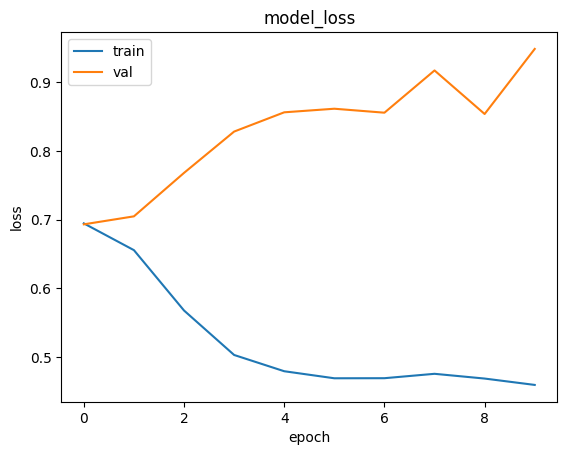

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

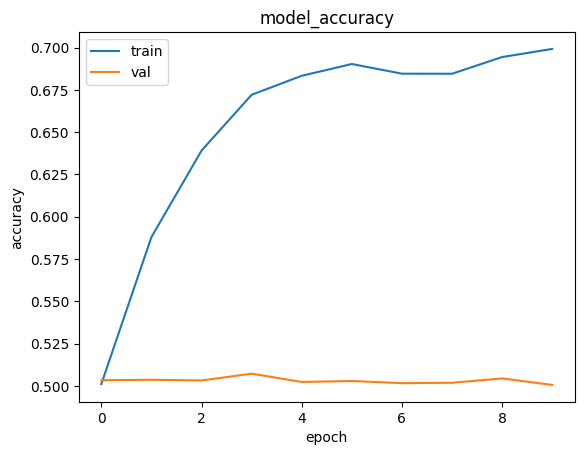

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [26]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(train_dataset)

391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6895 - loss: 0.4581


[0.4586522579193115, 0.6865599751472473]

## LSTM (MultiLayer and Bidirectional)

In [20]:
EMBEDDING_DIM = 64  # Size of word vectors

model = tf.keras.models.Sequential([  # Build model layer by layer

    Input(shape=(SEQUENCE_LENGTH,)),  # Input: sequence of words
    Embedding(VOCAB_SIZE, EMBEDDING_DIM),  # Turn words into vectors

    Bidirectional(LSTM(64, return_sequences=True)),  # LSTM reads forward & backward, keeps full output
    Bidirectional(LSTM(32)),  # Another LSTM, gives final output only

    Dense(64, activation='relu'),  # Hidden layer with ReLU
    Dropout(0.5),  # Drop 50% neurons to avoid overfitting

    Dense(1, activation='sigmoid')  # Output: yes/no (binary)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 250, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 250, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 751,489 (2.87 MB)

 Trainable params: 751,489 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/lstm.keras'
#set up callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [52]:
#compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-2),
              metrics=['accuracy'])

In [53]:
#fit the model
history=model.fit(
                  train_dataset,
                  validation_data = val_dataset,
                  epochs=10,
                  callbacks = [model_checkpoint_callback]
                  )

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - accuracy: 0.6931 - loss: 0.5535 - val_accuracy: 0.8614 - val_loss: 0.3101
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/step - accuracy: 0.9000 - loss: 0.2635 - val_accuracy: 0.8452 - val_loss: 0.3804
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 52ms/step - accuracy: 0.9244 - loss: 0.2133 - val_accuracy: 0.8469 - val_loss: 0.4243
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.9220 - loss: 0.2108 - val_accuracy: 0.8166 - val_loss: 0.4574
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.8794 - loss: 0.3054 - val_accuracy: 0.8108 - val_loss: 0.4449
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 56ms/step - accuracy: 0.8741 - loss: 0.3098 - val_accuracy: 0.8170 - val_loss: 0.4425
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.8883 - loss: 0.2823 - val_accuracy: 0.8242 - val_loss: 0.4454
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.9033 - loss: 0.2439 - 

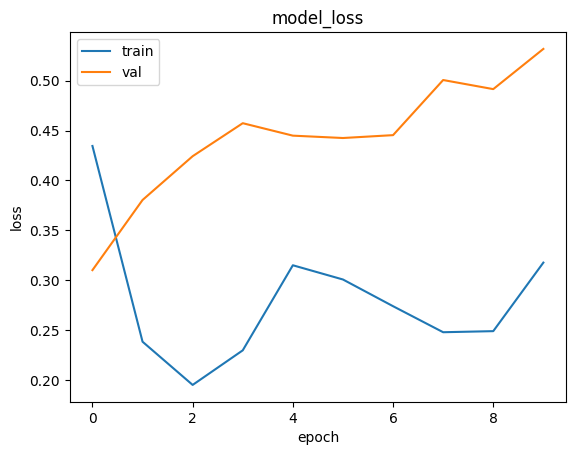

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

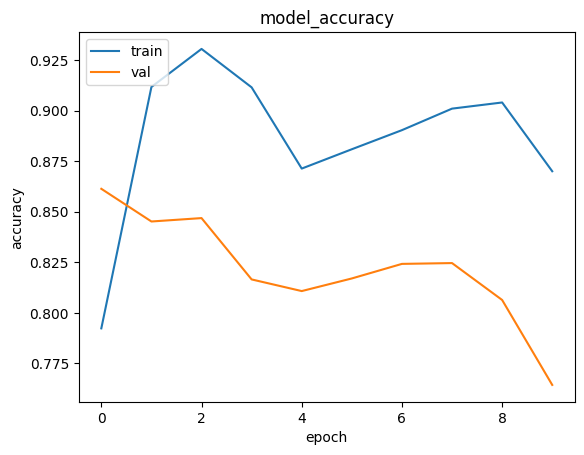

In [55]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [56]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(train_dataset)

391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.8239 - loss: 0.3828


[0.378551185131073, 0.8280400037765503]

## GRU (MultiLayer and Bidirectional)

In [82]:
EMBEDDING_DIM = 64  # Word vector size

model = tf.keras.models.Sequential([  # Sequential model

    Input(shape=(SEQUENCE_LENGTH,)),  # Input sequence
    Embedding(VOCAB_SIZE, EMBEDDING_DIM),  # Word to vector

    Bidirectional(GRU(64, return_sequences=True)),  # GRU (forward + backward), keep sequence
    Bidirectional(GRU(32)),  # GRU, return final output

    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.5),  # Prevent overfitting

    Dense(1, activation='sigmoid')  # Binary output
])

model.summary()  # Show model details

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 250, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 250, 128)       │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 725,249 (2.77 MB)

 Trainable params: 725,249 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/gru.keras'
#set up callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [85]:
#compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [86]:
#fit the model
history=model.fit(
                  train_dataset,
                  validation_data = val_dataset,
                  epochs=10,
                  callbacks = []
                  )

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.5136 - loss: 0.6927 - val_accuracy: 0.5967 - val_loss: 0.6780
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.7199 - loss: 0.5504 - val_accuracy: 0.8534 - val_loss: 0.3415
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.8839 - loss: 0.2947 - val_accuracy: 0.8309 - val_loss: 0.3940
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - accuracy: 0.9126 - loss: 0.2385 - val_accuracy: 0.8368 - val_loss: 0.4193
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.9281 - loss: 0.2051 - val_accuracy: 0.8496 - val_loss: 0.3989
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.9367 - loss: 0.1882 - val_accuracy: 0.8542 - val_loss: 0.4104
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.9405 - loss: 0.1713 - val_accuracy: 0.8542 - val_loss: 0.4259
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.9413 - loss: 0.1640 - 

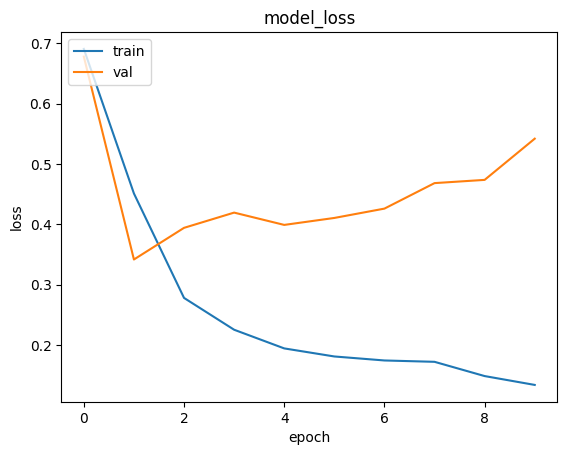

In [87]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

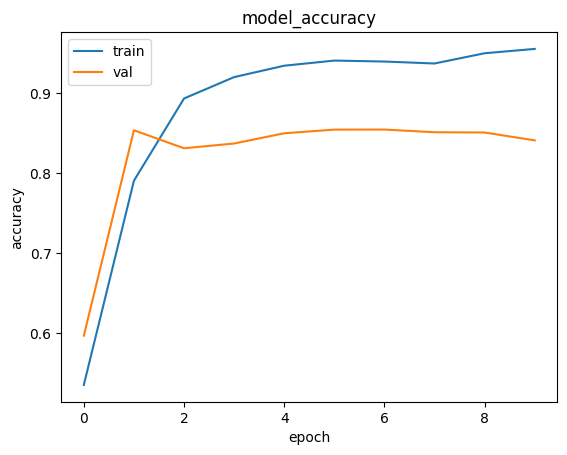

In [88]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [89]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(train_dataset)

391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9653 - loss: 0.1071


[0.0975496843457222, 0.9692000150680542]

## Conv1D

In [91]:
EMBEDDING_DIM = 300
model = tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Conv1D(32,3,activation='relu',),
    Flatten(),

    Dense(32, activation='relu'),
    Dropout(0.5),

    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 250, 300)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 248, 32)        │        28,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7936)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │       253,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,282,849 (12.52 MB)

 Trainable params: 3,282,849 (12.52 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/conv_1d.keras'

#add call back
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [93]:
#compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'],
              run_eagerly=True)

In [94]:
#fit the model
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 103ms/step - accuracy: 0.5110 - loss: 0.6930 - val_accuracy: 0.5747 - val_loss: 0.6861
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 107ms/step - accuracy: 0.6653 - loss: 0.6196 - val_accuracy: 0.8543 - val_loss: 0.3507
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 97ms/step - accuracy: 0.8737 - loss: 0.3162 - val_accuracy: 0.8670 - val_loss: 0.3202
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - accuracy: 0.9088 - loss: 0.2414 - val_accuracy: 0.8678 - val_loss: 0.3186
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 93ms/step - accuracy: 0.9328 - loss: 0.1967 - val_accuracy: 0.8665 - val_loss: 0.3333
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 97ms/step - accuracy: 0.9458 - loss: 0.1659 - val_accuracy: 0.8599 - val_loss: 0.3519
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step - accuracy: 0.9564 - loss: 0.1405 - val_accuracy: 0.8562 - val_loss: 0.3769
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 98ms/step - accuracy: 0.9645 - loss: 0.1177

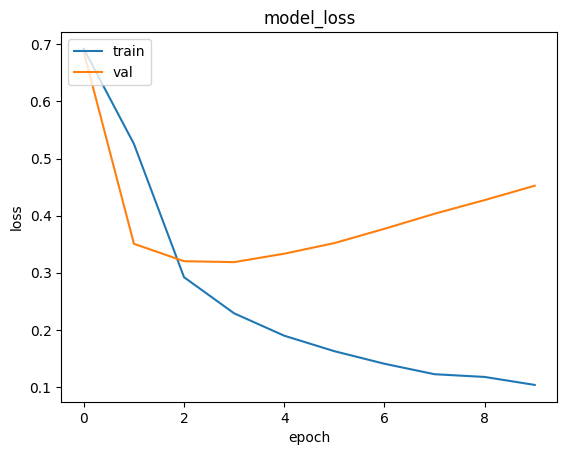

In [95]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

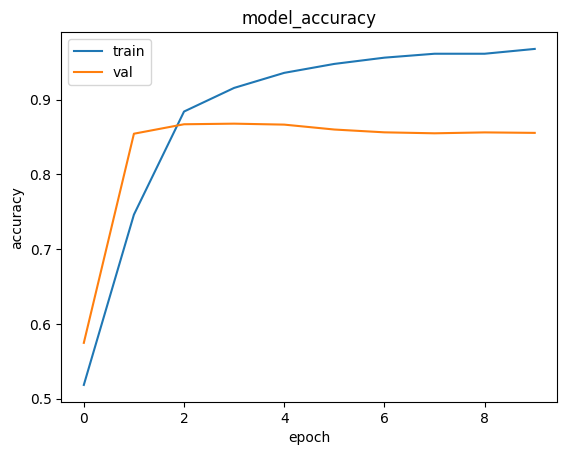

In [96]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [98]:
model.load_weights(checkpoint_filepath)

In [97]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.8491 - loss: 0.4571


[0.4486449956893921, 0.8523200154304504]

## Pretrained Word2Vec[Gensim]

### Evaluation

# Testing

## Inference Ready Testing

# Visualize Embeddings